In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
# Hyperparameters
BATCH_SIZE = 64
IMG_SIZE = 96  # Upscale CIFAR-10 images (32x32) to 96x96 for MobileNetV2
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def resize_and_preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = preprocess_input(image)
    return image, label

In [4]:
# Load CIFAR-10 test dataset
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_test = np.squeeze(y_test)

In [5]:
model = tf.keras.models.load_model("model.keras")

In [6]:
#preprocessing data
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(resize_and_preprocess, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [7]:
loss, accuracy = model.evaluate(test_dataset)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9132 - loss: 0.2790


In [8]:
loss, accuracy

(0.2672818899154663, 0.9153000116348267)

In [9]:
# FGSM attack
def fgsm_attack(image, label, epsilon=0.01):
    image = tf.convert_to_tensor(image)
    # Convert label to tensor with a batch dimension
    label_tensor = tf.convert_to_tensor([label])
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(tf.expand_dims(image, axis=0))
        loss = tf.keras.losses.sparse_categorical_crossentropy(label_tensor, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)
    return adversarial_image


In [10]:
# PGD Attack
def pgd_attack(image, label, epsilon=0.01, alpha=0.005, num_iter=10):
    image = tf.convert_to_tensor(image)
    label_tensor = tf.convert_to_tensor([label])
    adv_image = tf.identity(image)
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(tf.expand_dims(adv_image, axis=0))
            loss = tf.keras.losses.sparse_categorical_crossentropy(label_tensor, prediction)
        gradient = tape.gradient(loss, adv_image)
        adv_image = adv_image + alpha * tf.sign(gradient)
        perturbation = tf.clip_by_value(adv_image - image, -epsilon, epsilon)
        adv_image = tf.clip_by_value(image + perturbation, -1, 1)
    return adv_image

In [11]:
def deepfool_attack(image, num_classes=10, overshoot=0.0000001, max_iter=1):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    perturbed_image = tf.identity(image)

    # Get original prediction and label
    with tf.GradientTape() as tape:
        tape.watch(perturbed_image)
        logits = model(tf.expand_dims(perturbed_image, axis=0))[0]
    orig_label = tf.argmax(logits)

    r_tot = tf.zeros_like(image)
    i = 0

    while i < max_iter:
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(perturbed_image)
            logits = model(tf.expand_dims(perturbed_image, axis=0))[0]

        current_label = tf.argmax(logits)
        if current_label != orig_label:
            break

        # Compute gradients for all class logits
        gradients = []
        for k in range(num_classes):
            with tf.GradientTape() as tape2:
                tape2.watch(perturbed_image)
                logit_k = model(tf.expand_dims(perturbed_image, axis=0))[0, k]
            grad_k = tape2.gradient(logit_k, perturbed_image)
            gradients.append(grad_k)
        gradients = tf.stack(gradients)

        # Compute minimal perturbation
        f_orig = logits[orig_label]
        perturbs = []
        for k in range(num_classes):
            if k == orig_label:
                continue
            w_k = gradients[k] - gradients[orig_label]
            f_k = logits[k] - f_orig
            norm_w = tf.norm(tf.reshape(w_k, [-1])) + 1e-8
            pert_k = tf.abs(f_k) / norm_w
            perturbs.append((pert_k, w_k))

        # Choose the closest decision boundary
        perturbs.sort(key=lambda x: x[0])
        pert_k, w_k = perturbs[0]

        # Compute minimal directional perturbation (no sign scaling)
        r_i = (pert_k * w_k) / (tf.norm(w_k) + 1e-8)
        r_tot += r_i

        # Apply accumulated perturbation with small overshoot
        perturbed_image = image + (1 + overshoot) * r_tot
        perturbed_image = tf.clip_by_value(perturbed_image, -1, 1)

        i += 1

    return perturbed_image


In [12]:
def show_attack_examples(attack_fn, attack_name, epsilon=0.01, alpha=0.005, num_iter=10):
    # Get one batch of images and labels
    for images, labels in test_dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        break

    # Choose 5 sample images
    num_samples = 2
    indices = np.random.choice(len(images), num_samples, replace=False)
    original_images = images[indices]
    adv_images = []

    for i in range(num_samples):
        image = original_images[i]
        label = labels[indices[i]] if len(labels.shape)==1 else labels[i]
        if attack_name == "FGSM":
            adv = fgsm_attack(image, label, epsilon=epsilon)
        elif attack_name == "PGD":
            adv = pgd_attack(image, label, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
        elif attack_name == "DeepFool":
            adv = deepfool_attack(image)
        else:
            raise ValueError("Unknown attack type")
        adv_images.append(adv.numpy())

    # Plot original and adversarial images side by side
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))
    for i in range(num_samples):
        # Original image (convert from [-1, 1] to [0, 1])
        orig = (original_images[i] + 1) / 2.0
        adv = (adv_images[i] + 1) / 2.0
        axes[i, 0].imshow(np.clip(orig, 0, 1))
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original")

        axes[i, 1].imshow(np.clip(adv, 0, 1))
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"{attack_name} Attack")
    plt.tight_layout()
    plt.show()

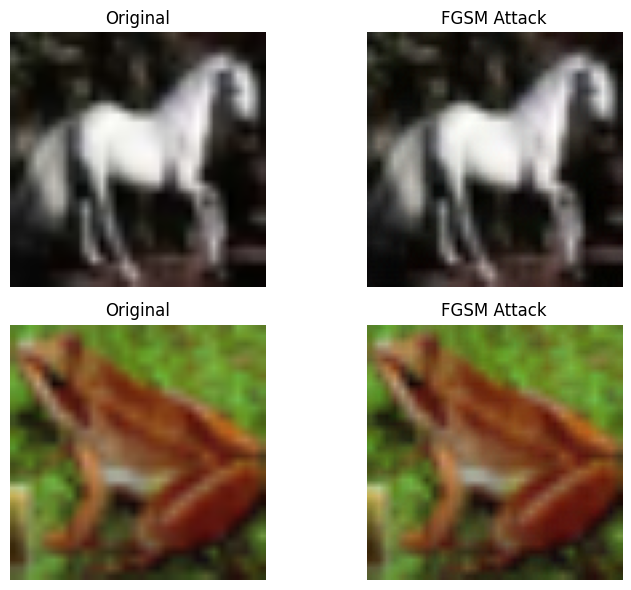

In [13]:
show_attack_examples(fgsm_attack, "FGSM", epsilon=0.01)

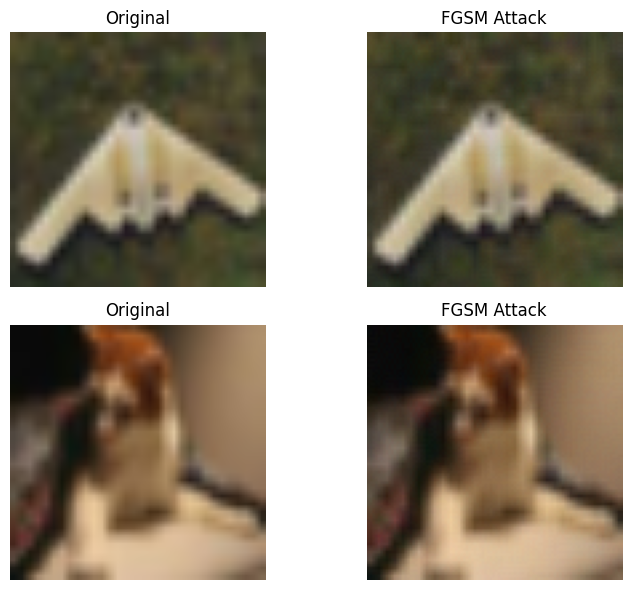

In [14]:
show_attack_examples(fgsm_attack, "FGSM", epsilon=0.01)

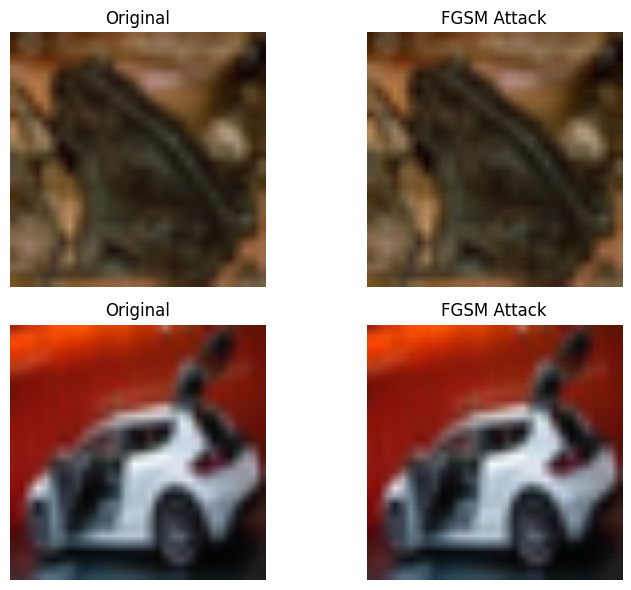

In [15]:
show_attack_examples(fgsm_attack, "FGSM", epsilon=0.01)

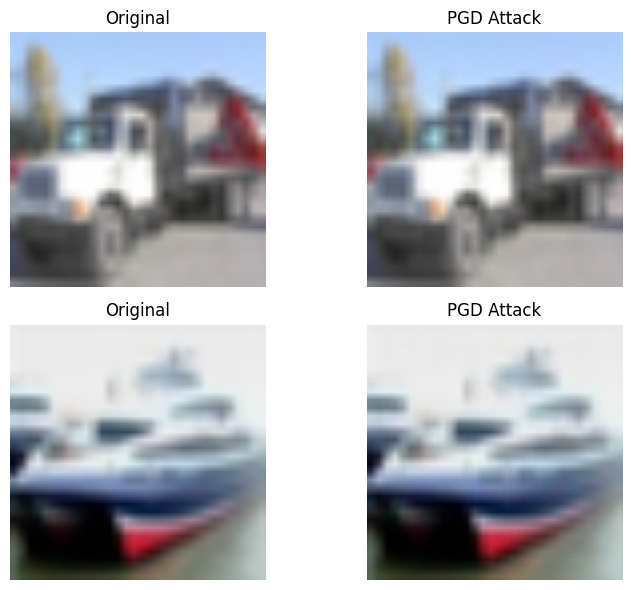

In [16]:
show_attack_examples(pgd_attack, "PGD", epsilon=0.01, alpha=0.005, num_iter=10)

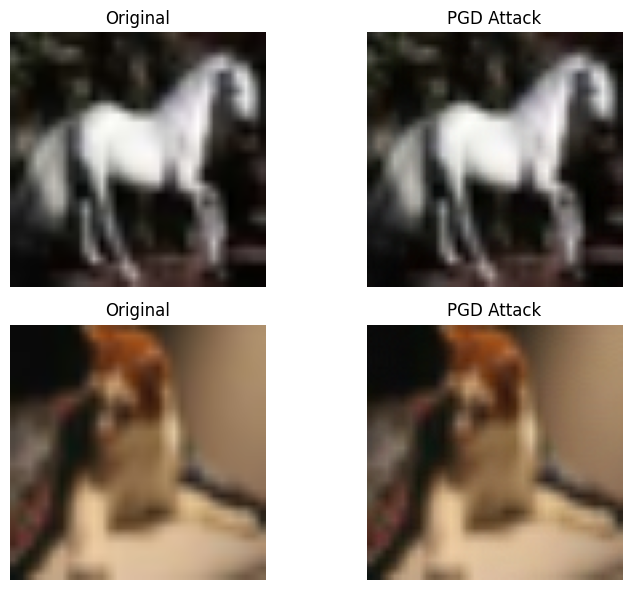

In [17]:
show_attack_examples(pgd_attack, "PGD", epsilon=0.01, alpha=0.005, num_iter=10)

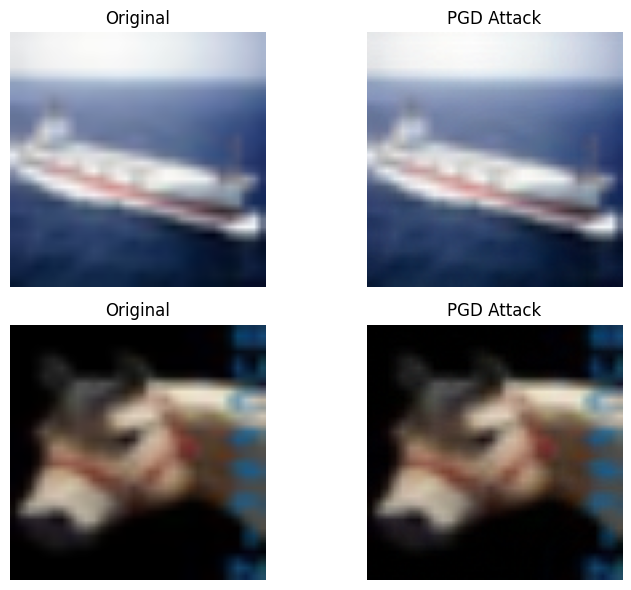

In [18]:
show_attack_examples(pgd_attack, "PGD", epsilon=0.01, alpha=0.005, num_iter=10)

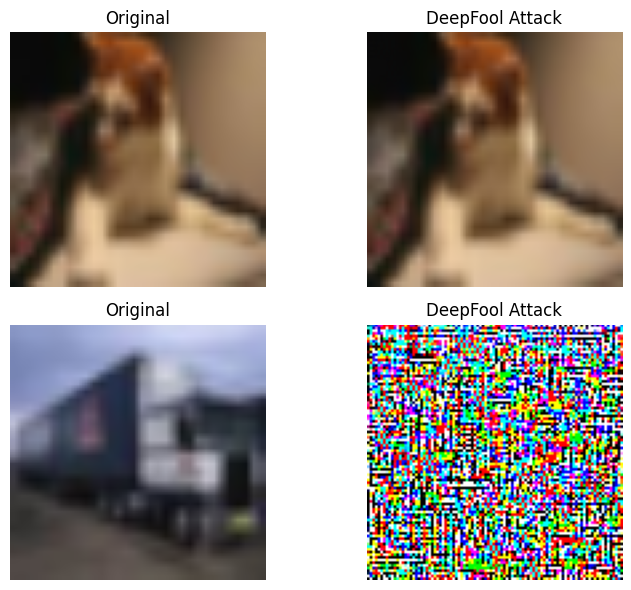

In [19]:
show_attack_examples(deepfool_attack, "DeepFool")

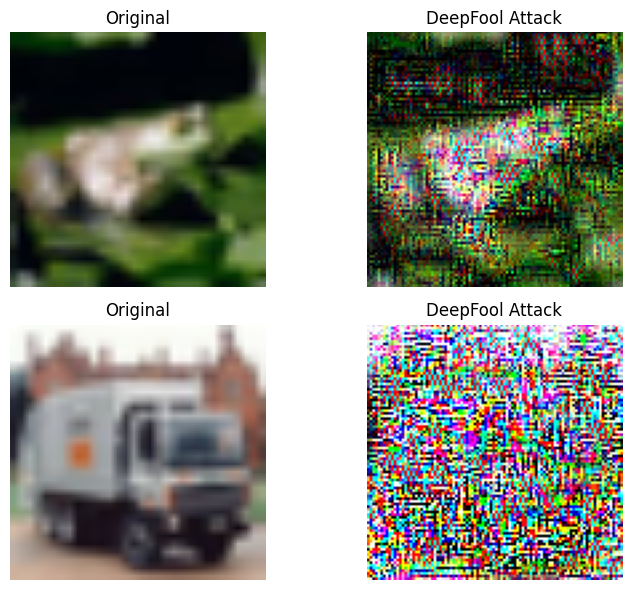

In [20]:
show_attack_examples(deepfool_attack, "DeepFool")

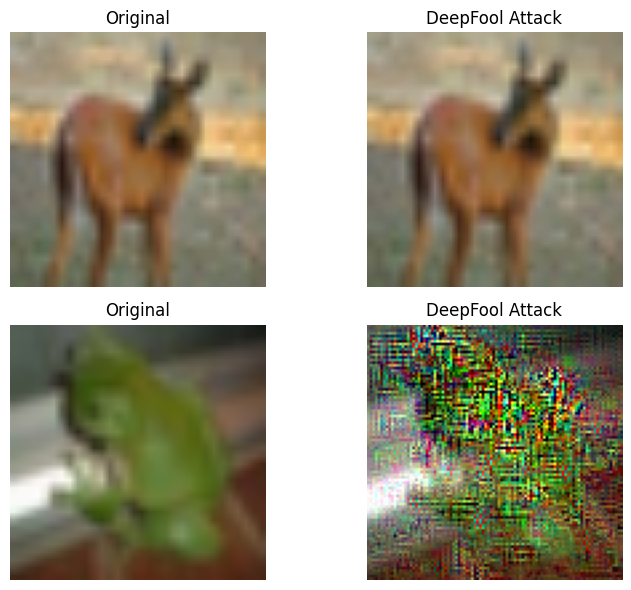

In [21]:
show_attack_examples(deepfool_attack, "DeepFool")

In [22]:
def get_test_dataset():
    # Load CIFAR-10 test dataset and preprocess
    (_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_test = np.squeeze(y_test)
    ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    ds = ds.map(resize_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

In [23]:
clean_ds = get_test_dataset()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [24]:
def count_samples(dataset):
    total = 0
    for images, labels in dataset:
        total += labels.shape[0]
    return total


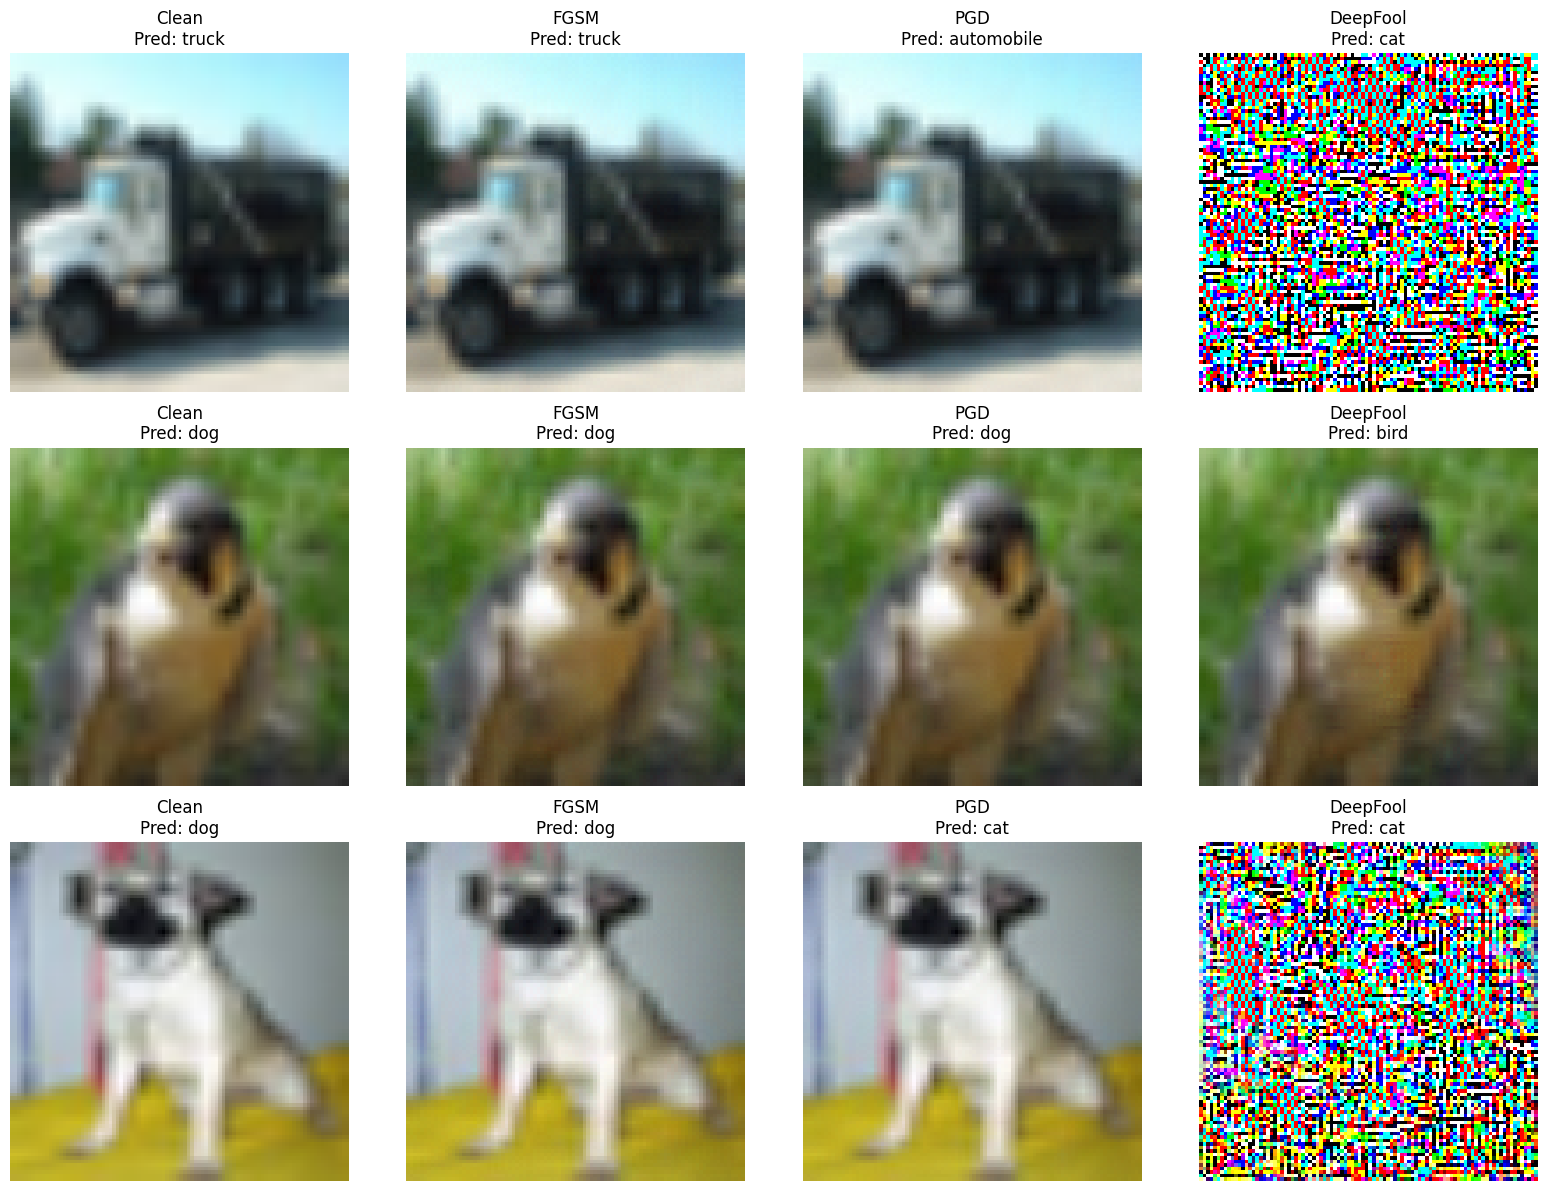

In [25]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# CIFAR-10 label names
label_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# Get a list of samples from the test dataset
def get_samples(num_samples=1000):
    ds = get_test_dataset().unbatch().take(num_samples)
    images, labels = [], []
    for img, lab in ds:
        images.append(img.numpy())  # Convert tensor to numpy
        labels.append(lab.numpy())  # Convert tensor to numpy
    return images, labels

# Function to get model prediction from an image
def get_prediction(image):
    # Ensure image is correctly shaped and normalized
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)
    return np.argmax(pred, axis=1)[0]  # Get class index

# Function to convert image from [-1,1] to [0,1] for display
def denormalize(image):
    return np.clip((image + 1.0) / 2.0, 0, 1)

# Pick 3 random images from the sample list
images_list, labels_list = get_samples(num_samples=1000)
indices = random.sample(range(len(images_list)), 3)

# Prepare lists to store results
clean_imgs, clean_preds = [], []
fgsm_imgs, fgsm_preds = [], []
pgd_imgs, pgd_preds = [], []
deepfool_imgs, deepfool_preds = [], []

for idx in indices:
    # Get the original image and label
    image = tf.convert_to_tensor(images_list[idx])
    label = labels_list[idx]

    # Clean image prediction
    clean_pred = get_prediction(image.numpy())
    clean_imgs.append(image.numpy())  # Convert back to NumPy
    clean_preds.append(label_names[clean_pred])

    # FGSM attack prediction
    fgsm_image = fgsm_attack(image, label, epsilon=0.01).numpy()
    fgsm_pred = get_prediction(fgsm_image)
    fgsm_imgs.append(fgsm_image)
    fgsm_preds.append(label_names[fgsm_pred])

    # PGD attack prediction
    pgd_image = pgd_attack(image, label, epsilon=0.01, alpha=0.005, num_iter=10).numpy()
    pgd_pred = get_prediction(pgd_image)
    pgd_imgs.append(pgd_image)
    pgd_preds.append(label_names[pgd_pred])

    # DeepFool attack prediction
    deepfool_image = deepfool_attack(image).numpy()
    deepfool_pred = get_prediction(deepfool_image)
    deepfool_imgs.append(deepfool_image)
    deepfool_preds.append(label_names[deepfool_pred])

# Display images: 3 rows (samples), 4 columns (Clean, FGSM, PGD, DeepFool)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
titles = ["Clean", "FGSM", "PGD", "DeepFool"]

for row in range(3):
    images_versions = [clean_imgs[row], fgsm_imgs[row], pgd_imgs[row], deepfool_imgs[row]]
    predictions = [clean_preds[row], fgsm_preds[row], pgd_preds[row], deepfool_preds[row]]

    for col in range(4):
        ax = axes[row, col]
        disp_img = denormalize(images_versions[col])  # Ensure correct scaling
        ax.imshow(disp_img)
        ax.set_title(f"{titles[col]}\nPred: {predictions[col]}")
        ax.axis("off")

plt.tight_layout()
plt.show()


In [26]:
def evaluate_model_on_dataset(dataset, name="Dataset"):
    y_true, y_pred = [], []
    total_loss = 0.0
    total_samples = 0

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    for batch_images, batch_labels in dataset:
        preds = model(batch_images, training=False)
        loss = loss_fn(batch_labels, preds).numpy()
        pred_classes = tf.argmax(preds, axis=1).numpy()
        y_true.extend(batch_labels.numpy())
        y_pred.extend(pred_classes)
        total_loss += loss * len(batch_labels)
        total_samples += len(batch_labels)

    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    avg_loss = total_loss / total_samples
    correct = sum(np.array(y_true) == np.array(y_pred))
    incorrect = total_samples - correct

    print(f"\n{name} Evaluation:")
    print(f"  Total Samples: {total_samples}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Correct Predictions: {correct}")
    print(f"  Incorrect Predictions: {incorrect}")
    return accuracy, avg_loss


In [27]:
@tf.function
def batched_fgsm_attack(images, labels, epsilon=0.01):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradients = tape.gradient(loss, images)
    adv_images = images + epsilon * tf.sign(gradients)
    adv_images = tf.clip_by_value(adv_images, -1, 1)
    return adv_images


In [28]:
@tf.function
def batched_pgd_attack(images, labels, epsilon=0.01, alpha=0.005, num_iter=10):
    adv_images = tf.identity(images)

    for _ in tf.range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(adv_images)
            predictions = model(adv_images, training=False)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
        gradients = tape.gradient(loss, adv_images)
        adv_images = adv_images + alpha * tf.sign(gradients)

        # Project perturbation
        perturbation = tf.clip_by_value(adv_images - images, -epsilon, epsilon)
        adv_images = tf.clip_by_value(images + perturbation, -1, 1)

    return adv_images


In [29]:
def build_adversarial_dataset_fast(dataset, attack_fn, attack_name="FGSM"):
    adv_images_all = []
    adv_labels_all = []

    print(f"\nBuilding {attack_name} dataset...")

    for images, labels in dataset:
        adv_images = attack_fn(images, labels)
        adv_images_all.append(adv_images)
        adv_labels_all.append(labels)

    adv_images_all = tf.concat(adv_images_all, axis=0)
    adv_labels_all = tf.concat(adv_labels_all, axis=0)

    adv_ds = tf.data.Dataset.from_tensor_slices((adv_images_all, adv_labels_all))
    return adv_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [30]:
def build_adversarial_dataset(attack_fn, name="Attack", **kwargs):
    adv_images = []
    adv_labels = []

    print(f"\nGenerating {name} dataset...")
    for images, labels in clean_ds:
        for img, label in zip(images, labels):
            adv_img = attack_fn(img, int(label), **kwargs)
            adv_images.append(adv_img.numpy())
            adv_labels.append(int(label.numpy()))

    adv_images = np.array(adv_images)
    adv_labels = np.array(adv_labels)

    ds = tf.data.Dataset.from_tensor_slices((adv_images, adv_labels))
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


In [31]:
evaluate_model_on_dataset(clean_ds, name="Clean Data")



Clean Data Evaluation:
  Total Samples: 10000
  Accuracy: 0.9153
  Loss: 0.2673
  Correct Predictions: 9153
  Incorrect Predictions: 847


(np.float64(0.9153), np.float32(0.2672819))

In [32]:
fgsm_ds = build_adversarial_dataset_fast(clean_ds, lambda x, y: batched_fgsm_attack(x, y, epsilon=0.01), attack_name="FGSM")
pgd_ds = build_adversarial_dataset_fast(clean_ds, lambda x, y: batched_pgd_attack(x, y, epsilon=0.01, alpha=0.005, num_iter=10), attack_name="PGD")


Building FGSM dataset...

Building PGD dataset...


In [33]:
evaluate_model_on_dataset(fgsm_ds, name="FGSM")


FGSM Evaluation:
  Total Samples: 10000
  Accuracy: 0.1820
  Loss: 5.1916
  Correct Predictions: 1820
  Incorrect Predictions: 8180


(np.float64(0.182), np.float32(5.191604))

In [34]:
evaluate_model_on_dataset(pgd_ds, name="PGD")


PGD Evaluation:
  Total Samples: 10000
  Accuracy: 0.0000
  Loss: 22.0664
  Correct Predictions: 0
  Incorrect Predictions: 10000


(np.float64(0.0), np.float32(22.066427))

In [ ]:
deepfool_ds = build_adversarial_dataset(lambda x, y: deepfool_attack(x), name="DeepFool")
evaluate_model_on_dataset(deepfool_ds, name="DeepFool Attack")


Generating DeepFool dataset...
